# SEN122A Statistical Analysis of Choice Behaviour 

## `Lab session 02A:`
## `The Mixed Logit model`

**Delft University of Technology**<br>
**Q2 2025**<br>
**Instructor:** Sander van Cranenburgh<br>
**TA:**  Gabriel Nova <br>

### `Instructions`

**Lab sessions aim to:**<br>
* Illustrate how models and theory discussed in the classroom work out in practice.
* Help you gather hands-on modelling and data analysis skills.


**Lab sessions are:**<br>
* Learning environments where you work with Python and get support from TA and fellow students.
* Not graded and do not have to be submitted.
* A good preparation for the graded partial exam.

### `Use of AI tools`
AI tools, such as ChatGPT and Co-pilot, are great tools to assist with programming. Moreover, in your later careers, you will work in a world where such tools are widely available. As such, we **encourage** you to use AI tools **effectively**. However, be careful not to overestimate the capacity of AI tools! AI tools cannot replace you: you still have to conceptualise the problem, dissect it and structure it to conduct proper analysis. We recommend being especially **reticent** with using AI tools for the more conceptual and reflection-oriented questions. <br>
Futhermore **be aware** that during the `partial exam`, you will not have access to these tools (since internet access will be restricted).

### `Workspace set-up`

Follow the instructions in the [`README`](../../README.md) file to set up your programming environment.

### `Application: Estimating the Value of Travel Time`

In this lab session, we will investigate the "Value of Travel Time" (VTT) distribution. The VTT of a traveller reflects the amount of money the traveller is **willing to pay** to reduce their travel time. The VTT is used to determine the benefits of new infrastructure projects. As travel time savings are the dominant and most salient benefits of new infrastructure, accurate inference of the distribution of the VTT is crucial for a rigorous underpinning of policy decisions. <br>

During this lab, we will apply Mixed Logit choice models. We aim to uncover how tastes for travel time and travel cost are distributed in the population. Most of the analyses in this lab session are carried out in the so-called willingness-to-pay space. Willingness-to-pay space facilitates the inference of the VTT distribution.<br>

For this study, we will use Stated Choice (SC) data (`Norway_VTT_2009.csv`) collected in 2009 to compute the Norwegian VTT. In this SC experiment, respondents faced nine choice tasks involving two alternatives and two attributes (travel cost and travel time). The data set consists of 5,832 participants, resulting in a total of 52,488 choice observations. The figure below shows one of the choice tasks (note that for the purposes of illustration we converted the currency unit (Kronor) into euros).

![SC](assets/sc_experiment.png)

**`Learning objectives lab session 02A`**

After completing the following exercises, you will be able to:
* Estimate Mixed Logit models that capture taste heterogeneity and panel effects
* Interpret the modelling outcomes of Mixed Logit models
* Specify utility models in Willingness-to-pay space



**`This lab consists of 4 parts and has 2 exercises`**

**Part 1**: Load and explore the data set

**Part 2**: Linear-additive RUM-MNL model

**Part 3**: Mixed Logit model for capturing taste heterogeneity 
- Exercise 1: "Mixed Logit model with a normally distributed beta_tt"

**Part 4**: Willingness-to-Pay space 
- Exercise 2: "Mixed Logit model with log-normally distributed VTT"



### `Import packages`

To begin, we will import all the libraries that we will use in this lab.

In [15]:
# Biogeme
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.biogeme_logging as blog
from biogeme import models
from biogeme.expressions import Beta, Variable, bioDraws, log, MonteCarlo, exp, exp


# General packages
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time
from pathlib import Path
from scipy.stats import norm, lognorm

# Pandas setting to show all columns when displaying a pandas dataframe
pd.set_option('display.max_columns', None)

In [16]:
# Add the utils folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

# Import the bio_estimation_fcns from the utils folder
from utils.bio_estimation_fcns import print_results, estimate_mnl, plot_distributions

We invoke a so-called `logger` which enables us to see the progress during estimation.<br>

In [17]:
# Initialize the logger, if it has not been initialized yet
try:
    logger
except NameError:    
    logger = blog.get_screen_logger(level=blog.INFO)
    print('Logger has been initialised')

## `1. Load and explore the data set` <br>

First, we load the data.

In [18]:
# 1. Load the data set
data_path = Path('data/Norway_VTT_2009.csv')
df = pd.read_table(data_path, sep=',')

# Show descriptive statistics
round(df.describe(),2)

,RespID,CostL,CostR,TimeL,TimeR,Chosen,Mode,Purpose,Gender,AgeClass,IncClass
count,52488.00,52488.00,52488.00,52488.00,52488.00,52488.00,52488.00,52488.00,52488.00,52488.00,52488.0
mean,32776.25,181.57,184.83,98.50,97.83,1.48,1.85,3.28,1.45,3.20,5.0
std,14995.46,281.07,286.95,134.33,133.42,0.50,1.80,1.64,0.50,0.99,2.3
min,32.00,4.00,4.00,6.00,6.00,1.00,1.00,1.00,1.00,1.00,1.0
25%,19195.25,25.00,25.00,18.00,17.00,1.00,1.00,2.00,1.00,2.00,4.0
50%,33039.50,69.00,70.00,40.00,40.00,1.00,1.00,4.00,1.00,3.00,5.0
75%,45333.00,236.00,238.00,121.00,122.00,2.00,2.00,5.00,2.00,4.00,6.0
max,60130.00,5282.00,5221.00,2011.00,1855.00,2.00,8.00,5.00,2.00,5.00,11.0


This data set contains the following variables:<br>

| Variable       | Description                                                  | Type    |
|---------------|-------------------------------------------------------------|---------|
| `RespID`        | Unique identifier for each survey response             | Integer |
| `CostL`         | Travel cost of left alternative [min]                  | Decimal |
| `CostR`         | Travel cost of right alternative [min]                 | Decimal |
| `TimeL`         | Travel time of left alternative [eur]                  | Decimal |
| `TimeR`         | Travel time of right alternative [eur]                 | Decimal |
| `Chosen`        | Indicates the alternative chosen       | Categorical |
| `Mode`          | Type of Transport mode               | Categorical    |
| `Gender`        | Gender of the respondent                                     | Categorical    |
| `AgeClass`      | Classification of the respondent's age                       | Categorical    |
| `IncClass`      | Classification of the respondent's income                    | Categorical    |
| `Purpose`       | Purpose of the trip                                     | Integer    |


Now, we take the following data preprocessing steps:

1. We keep only observations for the purpose 'long distance commute' and travel model 'car'.

2. We convert the unit of cost from Norwegian Krone to euros to ease interpretation.

In [19]:
# 1. Keep only entries purpose == 5 (Long distance trips) & Mode == 1 (Car)
df = df.loc[(df['Purpose'] == 5) & (df['Mode'] == 1)]

In [20]:
# 2. Convert the monetary unit to euros
NOK2euro_exchange_rate = 9
df[['CostL','CostR']] = df[['CostL','CostR']] .div(NOK2euro_exchange_rate)

## `2. Linear-additive RUM-MNL model`<br>
We first estimate a linear-aditive RUM-MNL model. This model serves as our **benchmark** to compare against. But, before we can do this, we need to create the Biogeme database object and specify the optimiser and logger settings. 

`Biogeme database`<br>
To estimate a model in Biogeme, we must create the data set as a Biogeme database object and the attributes as Biogeme variable objects.

In [21]:
# Create Biogeme database object
biodata = db.Database('Norway2009VTT', df)

# Create Biogeme variable objects
CostL  = Variable('CostL')
CostR  = Variable('CostR')
TimeL  = Variable('TimeL')
TimeR  = Variable('TimeR')

# The choice and availabilities of the alternatives
Chosen = Variable('Chosen')	

`Create a linear-additive RUM-MNL model`<br>
Now, we have the biogeme database object and set the environment, we can estimate our first model.

In [22]:
# Give the model a name
model_name = 'Benchmark MNL VTT model'

# Define model parameters
B_tt = Beta('B_tt', -0.1, None, None, 0)
B_tc = Beta('B_tc', -0.1, None, None, 0)

# Definition of the utility functions
VL = B_tt * TimeL + B_tc * CostL # (left alternative)
VR = B_tt * TimeR + B_tc * CostR # (right alternative)

# Associate utility functions with alternatives
V = {1: VL, 2: VR}     

# Associate the availability conditions with the alternatives
AV = {1: 1, 2: 1} # (both alternatives are always available)

# Estimate the model
results_mnl = estimate_mnl(V,AV,Chosen,biodata,model_name)

# Print the estimation statistics
print_results(results_mnl)

Biogeme parameters read from biogeme.toml. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: Newton with trust region for simple bounds 
Iter.            B_tc            B_tt     Function    Relgrad   Radius      Rho      
    0            -0.1            -0.1      1.3e+04         13     0.14    -0.91    - 
    1          -0.059           0.042      1.1e+04         10     0.14     0.14    + 
    2          -0.059           0.042      1.1e+04         10    0.071     -3.1    - 
    3          -0.059           0.042      1.1e+04         10    0.035    -0.12    - 
    4          -0.023          0.0064        7e+03        3.3    0.035     0.85    + 
    5          -0.059          -0.019      6.3e+03          1     0.35     0.94   ++ 
    6          -0.094           -0.03        6e+03       0.24      3.5      1.2   ++ 
    7           -0.11          -0.034        6e+03       0.02       35      1.1   ++ 
    8           -0.11          -0.034     



Results for model Benchmark MNL VTT model
Nbr of parameters:		2
Sample size:			10926
Excluded data:			0
Null log likelihood:		-7573.326
Final log likelihood:		-6033.756
Likelihood ratio test (null):		3079.141
Rho square (null):			0.203
Rho bar square (null):			0.203
Akaike Information Criterion:	12071.51
Bayesian Information Criterion:	12086.11

       Value  Rob. Std err  Rob. t-test  Rob. p-value
B_tc -0.1074        0.0037       -28.92           0.0
B_tt -0.0339        0.0014       -24.85           0.0


`Compute the Value of Travel Time`<br><br>
The linear-additive RUM-MNL model allows for easy computation of the (mean) VTT. <br>

$VTT = {\frac{dV}{dtt}}/{\frac{dV}{dtc}}$<br><br>
$VTT = \frac{\beta_{tt}}{\beta_{tc}}$

To take the ratio, we access the estimated betas in the `beta_hat` dataframe that was created in the previous cell.

In [23]:
# Compute the value of travel time and print the mean VTT
# We multiply by 60 to convert the value of travel time from minutes to hours
beta_hat_mnl = results_mnl.get_beta_values()
VTT_mnl = 60 * (beta_hat_mnl['B_tt'] / beta_hat_mnl['B_tc'])
print(f'Value of travel time MNL model:  €{VTT_mnl:.2f} per hour')

Value of travel time MNL model:  €18.96 per hour


## `3. Mixed Logit model for capturing taste heterogeneity`

### `3.1 Theory`<br>
In the MNL model, we postulate that tastes (e.g., 𝛽_tc) are equal across people in the population. As such, the taste parameter of an MNL model represents the mean taste in the population. The Mixed Logit (ML) model resolves this limitation. It explicitly models taste heterogeneity by means of random variables.

Mathematically, the unconditional choice probability is given by:

$P_{ni} = \int_{\beta_n}    [P_{ni}|\beta_n] \cdot f(\beta_n|\sigma)d\beta_n$

As can be seen, the MXL choice probability does not have a closed-form expression. Therefore, it needs to be approximated using simulation.<br>
To do that, we simulate the choice probabilities using a large number of draws `(R)` from the density function $f(β_n|\sigma)$. <br>
That is, we compute the conditional choice probability (which is a simple MNL) for each draw of $\beta_n^{r}$ with $r=1,..,R$, and then take the average across the draws to compute the unconditional choice probability.

<span style="text-decoration: overline;">P</span>$_{ni} = \frac{1}{R} \sum_{r=1}^R P_{ni}(β_n^r)$

Finally, we use the unconditional choice probabilities to compute the Log-Likelihood of the data given the model:

$LL(X,|\beta,\sigma)= \sum_{n=1}^N \sum_{j=1}^J y_{nj} \cdot ln($<span style="text-decoration: overline;">P</span>$_{nj})$

### `3.2 MXL with normally distributed taste parameters`

To estimate an MXL, model with normally distributed taste parameters, we must specify the random parameters (for all randomly distributed betas that we wish to estimate). To do this in Biogeme, we use the following code to construct the random parameter for $\beta_{tt}$:<br>

                B_tt_rnd = B_tt + sigma_tt * bioDraws('B_tt_rnd', 'NORMAL_HALTON2')

Note that apart from the random parameter for B_tt_rnd, the utility function is the same as under our linear-additive RUM-MNL benchmark model

`Model specification` <br>

Now, we will define random and nonrandom parameters, the utility functions, and their availabilities. <br>

In [24]:
# Give the model a name
model_name = 'ML with normal distributed B_tt and B_tc'

# Define the model parameters
B_tt = Beta('B_tt', -0.1, None, None, 0)
B_tc = Beta('B_tc', -0.1, None, None, 0)    
sigma_tt = Beta('sigma_tt', 1, None, None, 0)
sigma_tc = Beta('sigma_tc', 1, None, None, 0)

# Construct the random taste parameter for beta_tt
B_tt_rnd = B_tt + sigma_tt * bioDraws('B_tt_rnd', 'NORMAL_HALTON2')
B_tc_rnd = B_tc + sigma_tc * bioDraws('B_tc_rnd', 'NORMAL_HALTON2')

# Definition of the utility functions 
VL = B_tt_rnd * TimeL + B_tc_rnd * CostL
VR = B_tt_rnd * TimeR + B_tc_rnd * CostR   

# Create a dictionary to list the utility functions with the numbering of alternatives
V = {1: VL, 2: VR}
            
 # Create a dictionary to describe the availability conditions of each alternative
AV = {1: 1, 2: 1} 

`Estimation function for MXL` <br>

Now that we have specified the MXL model, we need to estimate it. To do so, we create the following function `estimate_mxl` which we can re-use.

The estimation function takes the following inputs:
* Dictionary with the utilities functions for each alternative (**V**)
* Dictionary with the availabilities for each alternative (**AV**)
* Chosen alternatives array (**CHOICE**)
* Biogeme database which contains the relevant attributes and characteristics (**database**)
* Model name (**"string"**)
* Number of draws for the simulation (**num_draws**) (default = 100)

The function uses Monte Carlo simulation to **simulate the log-likelihood function** for estimating the model parameters.

In [ ]:
# This function estimates the MXL model and returns the estimation results
def estimate_mxl(V,AV,CHOICE,biodata,model_name, num_draws = 100):
    
    # The conditional probability of the chosen alternative is a logit
    condProb = models.logit(V, AV ,CHOICE)

    # The unconditional probability is obtained by simulation
    uncondProb = MonteCarlo(condProb)

    # The Log-likelihood is the log of the unconditional probability
    LL = log(uncondProb)

    # Create the Biogeme estimation object containing the data and the model
    biogeme = bio.BIOGEME(biodata , LL, number_of_draws=num_draws)

    # Set reporting levels
    biogeme.generate_pickle = False
    biogeme.generate_html = False
    biogeme.save_iterations = False
    biogeme.modelName = model_name

    # Estimate the parameters and print the results
    results = biogeme.estimate()
    return results

Now, let's estimate the model!

In [ ]:
# Estimate the model and print the results
num_draws = 100
results_mxl_normal = estimate_mxl(V,AV,Chosen,biodata,model_name,num_draws)

# Print the results
print_results(results_mxl_normal)

Biogeme parameters read from biogeme.toml. 
The number of draws (125) is low. The results may not be meaningful. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: Newton with trust region for simple bounds 
Iter.            B_tc            B_tt        sigma_tc        sigma_tt     Function    Relgrad   Radius      Rho      
    0           -0.99           -0.25             0.4           -0.16      5.5e+03    0.00046       10     0.97   ++ 
    1           -0.99           -0.25             0.4           -0.16      5.5e+03    1.1e-05       10        1   ++ 




Number of estimated parameters:	4
Sample size:	10926
Excluded observations:	0
Init log likelihood:	-5549.744
Final log likelihood:	-5549.643
Likelihood ratio test for the init. model:	0.202798
Rho-square for the init. model:	1.83e-05
Rho-square-bar for the init. model:	-0.000702
Akaike Information Criterion:	11107.29
Bayesian Information Criterion:	11136.48
Final gradient norm:	9.7778E-02
Number of draws:	125
Draws generation time:	0:00:01.229132
Types of draws:	['B_tc_rnd: NORMAL_HALTON2', 'B_tt_rnd: NORMAL_HALTON2']
Nbr of threads:	10

           Value  Rob. Std err  Rob. t-test  Rob. p-value
B_tc     -0.9993        0.2754        -3.63           0.0
B_tt     -0.2538        0.0685        -3.71           0.0
sigma_tc  0.4007        0.1112         3.60           0.0
sigma_tt -0.1596        0.0509        -3.14           0.0


`Visualisation of the estimated random parameters`<br>
Visualisation of the estimated random parameters helps to get a feeling for their shape. To visualise the distributions we use a dedicated function from `utils.bio_estimation_fcns`. This function takes as input a dictionary that specifies the distribution type for each random parameter you want to plot, as well as the range we want to plot over. Note that we names of the random parameters should match for this to work. <br>
For instance, to plot the distribution of "tt" the names of the parameters associated with tt should end with "_tt" (thus, be named "beta_tt" and "sigma_tt" or "b_tt" and "sig_tt").<br>

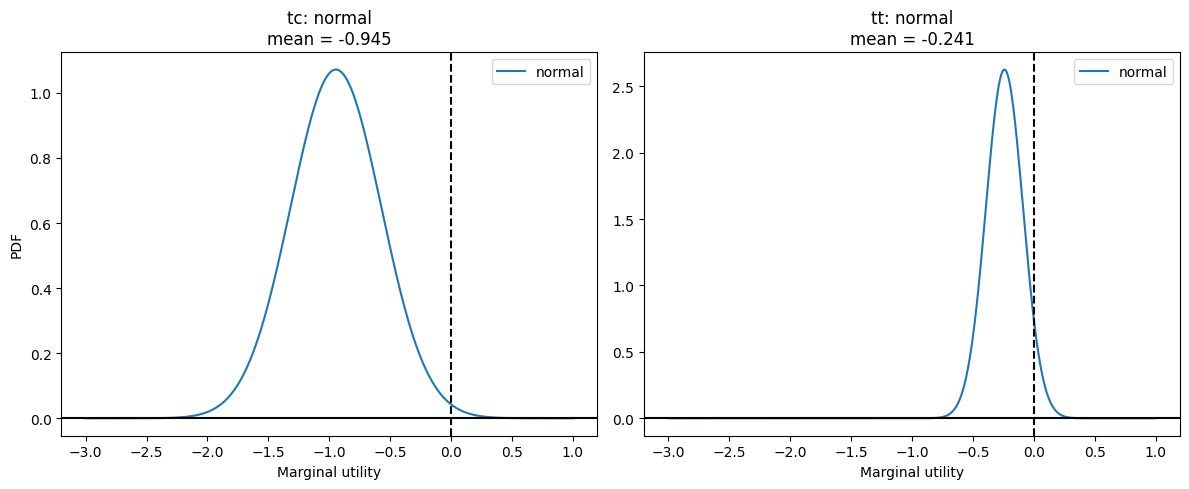

In [13]:
# Visualise the distribution of the random parameters using a dedicated function from utils.bio_estimation_fcns
# Create the dictionary with the distribution types
distr_types = {
    'tc':  {'dist': 'normal'},
    'tt':  {'dist': 'normal'},
}
# Plot the distributions of the random parameters, by passing it the biogeme results, the dictionary with the distribution types, and the x-axis limits
plot_distributions(results_mxl_normal, distr_types, xmin = -3, xmax = 1)

### `3.3 Reflection`<br>
We can make the following observations from the results of the MXL model:
1. The model fits the data better than the linear-additive RUM-MNL model. So this model is preferred over the linear-additive RUM-MNL model.
2. The estimated standard deviations of the random parameters are significant, indicating that there is substantial taste heterogeneity in the population.


**However**, the MXL model with two normally distributed random parameters does not provide a way to compute the VTT. When we would compute the VTT by taking the ratio of $\beta_{time}$ over $\beta_{cost}$ we end up dividing by $\beta_{tc}$ because the **normal** distribution has mass at zero, see the left-hand side plot. In other words, the model predicts some people don't care about cost. This implies that when we compute the VTT, we divide by zero. In other words, people with $\beta_{tc} = 0$ have an infinite VTT. As a result, the mean VTT would be infinite as well. Thus, a normally distributed $\beta_{tc}$ is generally not a good idea if one want to compute the mean VTT.

## `Exercise 1: Mixed Logit model with a normally distributed beta_tt`

`A` Modify the code to estimate the MXL model above, such that only $\beta_{tt}$ is treated as a normally distributed random variable.

`B` Compute the **mean** VTT for this model. Since the normal distribution is symmetric, its mean is simply given by the mean of the random parameter.<br>
So, the mean VTT is given by  VTT_MXL = $60\cdot \frac{\beta_{tt}}{\beta_{tc}}$.

#### `Answers`

In [30]:
# A. 
# Give the model a name
model_name = 'ML with normal distributed B_tt only'

# Define the model parameters
B_tt = Beta('B_tt', -0.1, None, None, 0)
B_tc = Beta('B_tc', -0.1, None, None, 0)    
sigma_tt = Beta('sigma_tt', 1, None, None, 0)

# Construct the random taste parameter for beta_tt
B_tt_rnd = B_tt + sigma_tt * bioDraws('B_tt_rnd', 'NORMAL_HALTON2')

# Definition of the utility functions 
V_L = B_tt_rnd * TimeL + B_tc * CostL
V_R = B_tt_rnd * TimeR + B_tc * CostR   

# Create a dictionary to list the utility functions with the numbering of alternatives
V = {1: V_L, 2: V_R}
            
 # Create a dictionary to describe the availability conditions of each alternative
AV = {1: 1, 2: 1} 

# Estimate the model and print the results
num_draws = 100
results_mxl_normal_tt = estimate_mxl(V, AV, Chosen, biodata, model_name, num_draws)

# Print the results in a table
print_results(results_mxl_normal_tt)

Biogeme parameters read from biogeme.toml. 
The number of draws (100) is low. The results may not be meaningful. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: Newton with trust region for simple bounds 
Iter.            B_tc            B_tt        sigma_tt     Function    Relgrad   Radius      Rho      
    0            -0.1            -0.1               1      7.5e+03       0.35      0.5     -4.3    - 
    1            -0.6            0.26            0.86      6.7e+03       0.31      0.5     0.63    + 
    2           -0.87           -0.24            0.67        6e+03       0.14      0.5     0.86    + 
    3           -0.87           -0.24            0.67        6e+03       0.14     0.25     -6.5    - 
    4              -1           -0.26            0.42      5.9e+03       0.34     0.25     0.29    + 
    5           -0.78            -0.3            0.32      5.8e+03       0.32     0.25     0.42    + 
    6           -0.53           



Number of estimated parameters:	3
Sample size:	10926
Excluded observations:	0
Init log likelihood:	-7539.439
Final log likelihood:	-5743.571
Likelihood ratio test for the init. model:	3591.737
Rho-square for the init. model:	0.238
Rho-square-bar for the init. model:	0.238
Akaike Information Criterion:	11493.14
Bayesian Information Criterion:	11515.04
Final gradient norm:	9.8147E-02
Number of draws:	100
Draws generation time:	0:00:00.786457
Types of draws:	['B_tc_rnd: NORMAL_HALTON2', 'B_tt_rnd: NORMAL_HALTON2']
Nbr of threads:	10

           Value  Rob. Std err  Rob. t-test  Rob. p-value
B_tc     -0.4663        0.1126        -4.14           0.0
B_tt     -0.1425        0.0337        -4.23           0.0
sigma_tt  0.2001        0.0614         3.26           0.0


In [15]:
# B
# Compute the mean value of travel time
beta_hat_mxl_normal_tt = results_mxl_normal_tt.get_beta_values()
VTT_mxl_normal_tt = 60 * (beta_hat_mxl_normal_tt['B_tt'] / beta_hat_mxl_normal_tt['B_tc'])
print(f'Value of travel time MXL model:  €{VTT_mxl_normal_tt:.2f} per hour')

Value of travel time MXL model:  €18.34 per hour


## `4. Willingness-to-Pay space`

### `4.1. Theory`<br>

People are differently sensitive to cost. But, as discussed under 3.3, we cannot specify $\beta_{tc}$ as a randomly distributed parameter (or, to be more precise, not as one that uses a distribution which has support over the full domain, like a normal distribution). To circumvent this problem, we can cleverly re-parameterise our model. This reparametrisation involves a transformation from **`utility space`** to **`Willingness-to-Pay (WTP) space`**. This transformation allows us to estimate the VTT (distribution) directly, and simplifies the modelling. It works as follows:<br><br>


The utility specification in `utility space` is:

$V_1 = \beta_{tc} \cdot TC_1 + \beta_{tt} \cdot TT_1$<br>
$V_2 = \beta_{tc} \cdot TC_2 + \beta_{tt} \cdot TT_2$<br><br>

We factorise $\beta_{tc}$ in both utility functions. This gives us:

$V_1 = \beta_{tc} \cdot (TC_1 + (\frac{\beta_{tt}}{\beta_{tc}}) \cdot TT_1)$<br>
$V_2 = \beta_{tc} \cdot (TC_2 + (\frac{\beta_{tt}}{\beta_{tc}}) \cdot TT_2)$<br><br>

Noting that $VTT = \frac{\beta_{tt}}{\beta_{tc}}$, we obtain:

$V_1 = \beta_{tc} \cdot (TC_1 + VTT \cdot TT_1)$<br>
$V_2 = \beta_{tc} \cdot (TC_2 + VTT \cdot TT_2)$<br><br>

Hence, with this model, we can directly estimate the VTT (and $\beta_{tc}$). Therefore, this model is in the `Willingness-to-Pay space`.<br> 

**Starting values for estimating the VTT in the WTP space**<br>
Whenever we estimate a discrete choice model, we need to provide starting values for the optimisation algorithm. For conventional linear-additive RUM-MNL models, the starting values are inconsequential because of its concave log-likelihood function. However, for models estimated in WTP space and more complex models in general, the starting values can have impact. When estimating the VTT in the WTP space, it is good practice to provide reasonable starting values (thus a nonzero, positive VTT).

In the WTP space, we can use the following heuristic to determine the starting values for the VTT:<br>
Let's first see how this works out for a simple MNL model:

In [16]:
# Give the model a name
model_name = 'Benchmark MNL in WTP space'

# Define model parameters
vtt  = Beta('vtt', 10/60, None, None, 0) # Note that we use VTT of 10 euros/hr as the starting value. /60 converts minutes to hours
B_tc = Beta('B_tc', -0.1, None, None, 0) # Note that we use a reasonable starting value for B_tc (same as in the MNL model)

# Definition of the utility functions
VL = B_tc * (CostL + vtt * TimeL)
VR = B_tc * (CostR + vtt * TimeR)

# Associate utility functions with alternatives
V = {1: VL, 2: VR}     

# Associate the availability conditions with the alternatives
AV = {1: 1, 2: 1} 

# Estimate the model
results_wtp_mnl = estimate_mnl(V,AV,Chosen,biodata,model_name)

# Print the estimation statistics
print_results(results_wtp_mnl)

Biogeme parameters read from biogeme.toml. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: Newton with trust region for simple bounds 
Iter.            B_tc             vtt     Function    Relgrad   Radius      Rho      
    0            -0.1            0.17      6.4e+03       0.89      0.5      -12    - 
    1            -0.1            0.17      6.4e+03       0.89     0.25     -3.9    - 
    2            -0.1            0.17      6.4e+03       0.89     0.12    -0.17    - 
    3           -0.11            0.29      6.1e+03       0.23     0.12     0.85    + 
    4           -0.11            0.31        6e+03      0.013      1.2        1   ++ 
    5           -0.11            0.31        6e+03     0.0001      1.2        1   ++ 




Results for model Benchmark MNL in WTP space
Nbr of parameters:		2
Sample size:			10926
Excluded data:			0
Null log likelihood:		-7573.326
Final log likelihood:		-6033.756
Likelihood ratio test (null):		3079.141
Rho square (null):			0.203
Rho bar square (null):			0.203
Akaike Information Criterion:	12071.51
Bayesian Information Criterion:	12086.11

       Value  Rob. Std err  Rob. t-test  Rob. p-value
B_tc -0.1074        0.0037       -28.92           0.0
vtt   0.3160        0.0062        50.94           0.0


In [17]:
# Compute the value of travel time
beta_hat_wtp_mnl = results_wtp_mnl.get_beta_values()
VTT_wtp_mnl = 60 * beta_hat_wtp_mnl['vtt']
print(f'Value of travel time MNL model in WTP space:  €{VTT_wtp_mnl:.2f} per hour')

Value of travel time MNL model in WTP space:  €18.96 per hour


### `4.2 Reflection`<br>
Comparing these results with the benchmark MNL VTT model, we make two observations:
* We obtain `EXACTLY` the same VTT
* We obtain `EXACTLY` the same model fit 
* **We immediately obtain the VTT and the associated standard error!** 


### `4.3. MXL in Willingness-to-Pay space`

`MXL with normally distributed taste parameters`<br>
Now, let's see how WTP space enables us to directly estimate the VTT distribution in the context of the Mixed Logit model.

In [ ]:
# Give the model a name
model_name = 'ML WTP space with normally distributed vtt'

# Parameters definition enabling the construction of random parameters
mu_vtt = Beta('mu_vtt',     10/60, None, None, 0) # Note that we use VTT of 10 euros/hr as the starting value. /60 converts minutes to hours
B_tc   = Beta('B_tc',        -0.1, None, None, 0) # Note that we use a reasonable starting value for B_tc (same as in the MNL model)
sigma_vtt = Beta('sigma_vtt', 0.1, None, None, 0) # Note that we use a nonzero starting value for sigma_vtt

# Construction of random parameters
vtt_rnd = mu_vtt + sigma_vtt * bioDraws('vtt_rnd', 'NORMAL_HALTON2')

# Definition of the utility functions 
VL = B_tc * (CostL + vtt_rnd * TimeL)
VR = B_tc * (CostR + vtt_rnd * TimeR)   

# Create a dictionary to list the utility functions with the numbering of alternatives
V = {1: VL, 2: VR}

# Create a dictionary to describe the availability conditions of each alternative
AV = {1: 1, 2: 1} 

# Estimate the model
num_draws = 100
results_wtp_mxl_normal = estimate_mxl(V, AV, Chosen, biodata, model_name, num_draws)

# Print the results in a table
print_results(results_wtp_mxl_normal)

Biogeme parameters read from biogeme.toml. 
The number of draws (100) is low. The results may not be meaningful. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: Newton with trust region for simple bounds 
Iter.            B_tc          mu_vtt       sigma_vtt     Function    Relgrad   Radius      Rho      
    0            -0.1            0.17             0.1      6.3e+03       0.65      0.5     -3.5    - 
    1            -0.1            0.17             0.1      6.3e+03       0.65     0.25     -1.5    - 
    2           -0.18            0.42            0.14      6.2e+03       0.71     0.25     0.15    + 
    3           -0.43            0.26            0.37      5.8e+03       0.28     0.25     0.41    + 
    4           -0.68            0.29            0.48      5.8e+03      0.033     0.25     0.59    + 
    5           -0.43            0.31            0.44      5.8e+03      0.024      2.5     0.91   ++ 
    6           -0.43           



Number of estimated parameters:	3
Sample size:	10926
Excluded observations:	0
Init log likelihood:	-6309.31
Final log likelihood:	-5748.893
Likelihood ratio test for the init. model:	1120.834
Rho-square for the init. model:	0.0888
Rho-square-bar for the init. model:	0.0883
Akaike Information Criterion:	11503.79
Bayesian Information Criterion:	11525.68
Final gradient norm:	4.1747E-02
Number of draws:	100
Draws generation time:	0:00:00.786863
Types of draws:	['B_tc_rnd: NORMAL_HALTON2', 'B_tt_rnd: NORMAL_HALTON2', 'vtt_rnd: NORMAL_HALTON2']
Nbr of threads:	10

            Value  Rob. Std err  Rob. t-test  Rob. p-value
B_tc      -0.4285        0.0811        -5.28           0.0
mu_vtt     0.3064        0.0065        47.08           0.0
sigma_vtt  0.4215        0.0298        14.15           0.0


In [19]:
# Compute the value of travel time
beta_hat_wtp_mxl_normal = results_wtp_mxl_normal.get_beta_values()
VTT_wtp_mxl_normal = 60*beta_hat_wtp_mxl_normal['mu_vtt']
print(f'Value of travel time MXL model in WTP space:  €{VTT_wtp_mxl_normal:.2f} per hour')

Value of travel time MXL model in WTP space:  €18.38 per hour


`Visualisation of the estimated VTT distribution`<br>
To visualise the VTT distributions we use the dedicated function from `utils.bio_estimation_fcns`. 

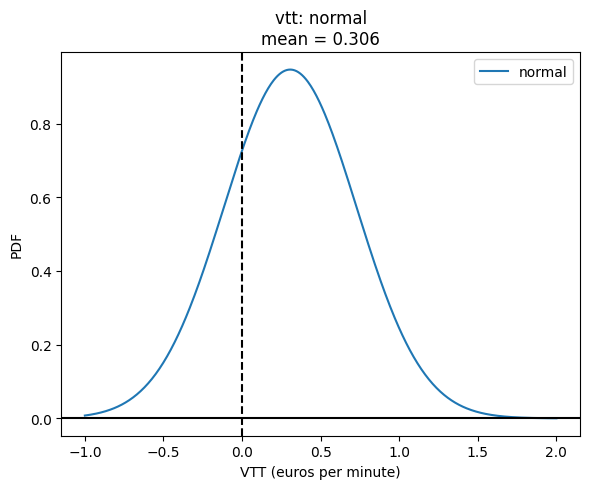

In [20]:
# Visualise the distribution of the VTT distribution
# Create the dictionary with the distribution types
distr_types = {
    'vtt':  {'dist': 'normal'},
}
# Plot the distributions of the random parameters, by passing it the biogeme results, the dictionary with the distribution types, and the x-axis limits
# Note that the unit of the VTT distribution is euros per minute
plot_distributions(results_wtp_mxl_normal, distr_types, xmin = -1, xmax = 120/60, xlabel='VTT (euros per minute)')

### `4.4 Reflection`<br>
* Using a Mixed Logit model in the Willingness-to-Pay space, we are able to estimate the distribution of the VTT **directly**. Hence, this model allows jointly for unobserved heterogeneity in cost and time without running into problems caused by dividing by zero.  


## `Exercise 2: Mixed Logit with log-normally distributed VTT`

`A` In the above plot showing the distribution of the VTT, we see that a substantial part of the VTT distribution lies in the negative domain. Explain why this is behaviourally counterintuitive and undisirable when we want to model the choice behaviour. 

One way to impose positive all VTTs are positive is by using a log-normal distribution. In contrast to the normal distribution, the log-normal distribution is defined over the positive domain only. Next, **you** will test if the assumption that the VTT distribution in the population is **`log-normally distributed`** explains the data **better** than the assumption that the VTT distribution in the population is normally distributed.<br>

To do that, you must create a random vtt parameter with a log-normal VTT distribution. Draws from the log-normal distribution are very simple to obtain from draws from the normal distribution. We only have to exponentiate draws from the normal distribution:<br>

            vtt_rnd = exp(mu_vtt + sigma_vtt  * bioDraws('vtt_rnd', 'NORMAL_HALTON2'))
            

Estimate this model and interpret its results.<br>


`B` Compare the log-likelihood of the MXL model with normally distributed VTT and with log-normally distributed VTT. Which model fits the data better?<br>

`C` What can you infer from the `vtt` and `sigma` parameters about the distribution of the VTT?<br>

`D` Compute the mean of the estimated log-normal distribution, i.e. `mean_lognormal` (based on your estimated `mu` and `sigma`). <br>

To do so, take a look at [https://en.wikipedia.org/wiki/Log-normal_distribution](https://en.wikipedia.org/wiki/Log-normal_distribution) to see how this is done. Look for the formula for the mean in the right-hand side panel on the web page.

`E` Plot the shape of the log-normal distribution for the estimated `mu` and `sigma`. <br>

#### `Answers`

In [ ]:
# Give the model a name
model_name = 'ML WTP space with log-normally distributed VTT'

# Parameters definition enabling the construction of random parameters
mu_vtt     = Beta('mu_vtt',      -1, None, None, 0) # Note that we use a reasonable starting value for mu_vtt. A negative mu_vtt does not imply that VTT is negative, as we will exponentiate it
B_tc       = Beta('B_tc',      -0.1, None, None, 0) # Note that we use a reasonable starting value for B_tc (same as in the MNL model)   
sigma_vtt  = Beta('sigma_vtt',  0.1, None, None, 0) # Note that we use a nonzero starting value for sigma_vtt

# Construction of random parameters   
vtt_rnd = exp(mu_vtt + sigma_vtt * bioDraws('vtt_rnd', 'NORMAL_HALTON2'))

# Definition of the utility functions 
VL = B_tc * (CostL + vtt_rnd * TimeL)
VR = B_tc * (CostR + vtt_rnd * TimeR)   

# Create a dictionary to list the utility functions with the numbering of alternatives
V = {1: VL, 2: VR}

# Create a dictionary to describe the availability conditions of each alternative
AV = {1: 1, 2: 1} 

# Estimate the parameters
num_draws = 100
results_wtp_mxl_lognormal = estimate_mxl(V, AV, Chosen, biodata, model_name, num_draws)

# Print the results
print_results(results_wtp_mxl_lognormal)

Biogeme parameters read from biogeme.toml. 


The number of draws (100) is low. The results may not be meaningful. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: Newton with trust region for simple bounds 
Iter.            B_tc          mu_vtt       sigma_vtt     Function    Relgrad   Radius      Rho      
    0           -0.15            -1.2             1.1        6e+03       0.49        1     0.16    + 
    1           -0.15            -1.2             1.1        6e+03       0.49      0.5     -1.7    - 
    2           -0.15            -1.2             1.1        6e+03       0.49     0.25   -0.047    - 
    3           -0.24            -1.5            0.96      5.7e+03       0.14      2.5     0.97   ++ 
    4           -0.34            -1.4               1      5.6e+03      0.057       25      1.2   ++ 
    5           -0.45            -1.4             1.1      5.6e+03      0.023  2.5e+02      1.3   ++ 
    6           -0.58            -1.5             1.1      5.6e+03     0.009



Number of estimated parameters:	3
Sample size:	10926
Excluded observations:	0
Init log likelihood:	-6081.7
Final log likelihood:	-5570.737
Likelihood ratio test for the init. model:	1021.924
Rho-square for the init. model:	0.084
Rho-square-bar for the init. model:	0.0835
Akaike Information Criterion:	11147.47
Bayesian Information Criterion:	11169.37
Final gradient norm:	1.0548E-01
Number of draws:	100
Draws generation time:	0:00:00.783088
Types of draws:	['vtt_rnd: NORMAL_HALTON2']
Nbr of threads:	10

            Value  Rob. Std err  Rob. t-test  Rob. p-value
B_tc      -0.9283        0.1646        -5.64           0.0
mu_vtt    -1.4639        0.0206       -70.93           0.0
sigma_vtt  1.1260        0.0291        38.64           0.0


`A` Explain why this is behaviourally counterintuitive and undisirable when we want to model the choice behaviour. ?<br>

        --> In general, people prefer to arrive quicker at their destination rather than later. The fact that we see a substantial part of the VTT distribution in the negative domain is due to the assumption that the VTT is normally distributed. This distribution is defined over the full domain (-inf,inf). As such, it allows for negative VTTs. From the choice modeller's perspective, this is undesirable because it may cause bias in the estimate of the mean VTT. If indeed everyone has a positive VTT, but the model **imposes** some people to have a negative VTT, the mean VTT will be biased downwards. This is undesirable because it may lead to an underestimation of the benefits of new infrastructure projects, which in turn may lead to suboptimal policy decisions.

`B` Compare the log-likelihood of the MXL model with normal distribution and with log-normal distribution. Which model fits better?<br>

        --> The log-normal distribution fits better, as it has a higher log-likelihood (-5570.737 vs -5739.896)

`C` What can you conclude from the `vtt` and `sigma` parameters?<br>

        --> The parameters are significant, and negative. But furthermore hard to interpret

`D` Compute the mean of the estimated log-normal distribution, i.e. `mean_lognormal` (based on your estimated `mu` and `sigma`) <br>

        --> The mean of the log-normal VTT distribution is ~€26 per hour

In [13]:
beta_hat_wtp_mxl_lognormal = results_wtp_mxl_lognormal.get_beta_values()
mu = beta_hat_wtp_mxl_lognormal['mu_vtt']
sigma = beta_hat_wtp_mxl_lognormal['sigma_vtt']
mean_lognormal = np.exp(mu + np.square(sigma)/2) * 60
print(f'The mean of the log-normal VTT distribution is: €{mean_lognormal:.2f} per hour')

The mean of the log-normal VTT distribution is: €26.16 per hour


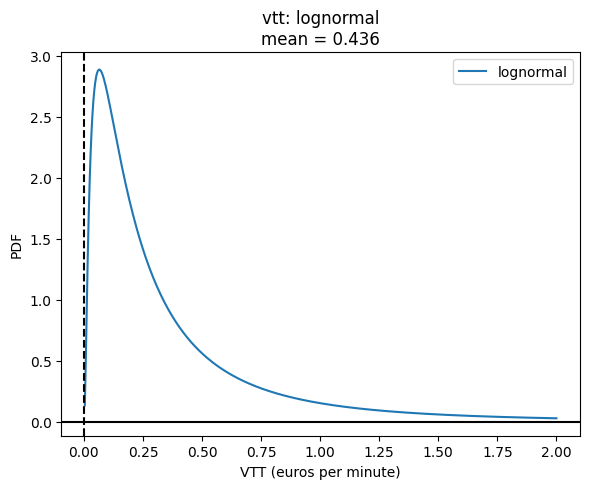

In [14]:
# E
# Visualise the distribution of the VTT distribution
# Create the dictionary with the distribution types
distr_types = {
    'vtt':  {'dist': 'lognormal','sign' : 1},
}
# Plot the distributions of the random parameters, by passing it the biogeme results, the dictionary with the distribution types, and the x-axis limits
# Note that the unit of the VTT distribution is euros per minute
plot_distributions(results_wtp_mxl_lognormal, distr_types, xmin = 0, xmax = 120/60, xlabel='VTT (euros per minute)')

## END 🎉<br>
### Now, you can continue with Lab 01B